## Hiragana
use CNN to learn and recognize hiraggana


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
import random, math, os

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

#for CNN model
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D


Import and organize data

In [2]:
## Load the dataset
from organize_data import download_hiragana_dataset

download_hiragana_dataset()

In [3]:
## import data into a list
## construct datatable
from organize_data import create_handwriting_table

handwriting_table = create_handwriting_table()
handwriting_table.head()

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a


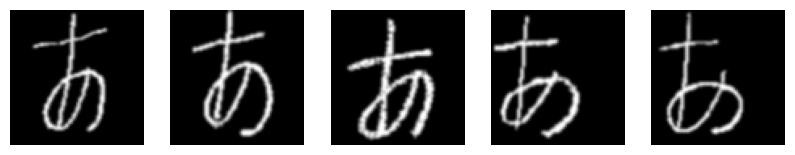

In [4]:
# show the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table.Handwriting[i], cmap='gray')
    ax[i].axis('off')

## Image preprocess


In [5]:
## process images with threshold = 40
from image_process import im_clean, im_bin, im_reshape, IMG_SIZE
img_rows, img_cols = IMG_SIZE
handwriting_table.Handwriting = handwriting_table.Handwriting.map(lambda img: im_reshape(im_clean(img), img_rows, img_cols))

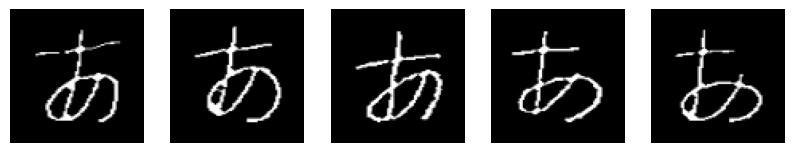

In [6]:
# show the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table.Handwriting[i], cmap='gray')
    ax[i].axis('off')

In [7]:
handwriting_table.Handwriting[0].shape

(84, 84)

## Import another dataset
Import a new dataset created by Wishyut.

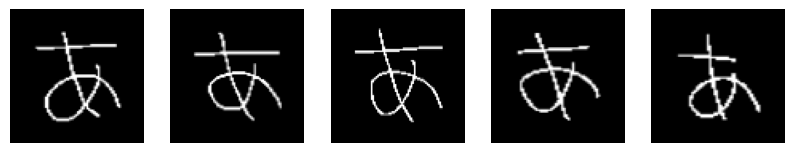

In [8]:
from organize_data import get_handwriting_wishyut
handwriting_table_wishyut = get_handwriting_wishyut()

fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table_wishyut.Handwriting[i], cmap='gray')
    ax[i].axis('off')

Organizing Romanji labels
* Organize the different labels with the same pronunciation

In [9]:
# create a function that maps {'hu', 'si', 'ti', 'tu'} to {'fu', 'shi', 'chi', 'tsu'}
from label_process import map_to_hiragana
# apply the function to the Romanji column
handwriting_table.Romanji = handwriting_table.Romanji.map(map_to_hiragana)
handwriting_table_wishyut.Romanji = handwriting_table_wishyut.Romanji.map(map_to_hiragana)

In [10]:
## combine two tables
# handwriting_table = handwriting_table.append(handwriting_table_wishyut, ignore_index=True) # old!
handwriting_table = pd.concat([handwriting_table, handwriting_table_wishyut])
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a
...,...,...,...
400,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_5.png,yu
401,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_6.png,yu
402,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_7.png,yu
403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_8.png,yu


## Add numerical label to each Romanji (for categorization)

In [11]:
## add labels to the datatable w.r.t. the romanji
from label_process import romanji_to_dict

romanji_dict = romanji_to_dict(handwriting_table["Romanji"])
romanji_categories = len(romanji_dict)
handwriting_table["Label"] = handwriting_table["Romanji"].map(lambda x: romanji_dict[x])

print(romanji_dict)
print(romanji_categories)
handwriting_table.head()

{'sa': 0, 'ni': 1, 'e': 2, 'ra': 3, 'yu': 4, 'i': 5, 'ta': 6, 'ji': 7, 'ko': 8, 'nu': 9, 're': 10, 'ro': 11, 'chi': 12, 'ba': 13, 'so': 14, 'mu': 15, 'yo': 16, 'su': 17, 'mo': 18, 'o': 19, 'ke': 20, 'tsu': 21, 'se': 22, 'ki': 23, 'n': 24, 'te': 25, 'a': 26, 'me': 27, 'ne': 28, 'fu': 29, 'ku': 30, 'wo': 31, 'shi': 32, 'u': 33, 'mi': 34, 'ya': 35, 'wa': 36, 'ho': 37, 'ri': 38, 'he': 39, 'ru': 40, 'hi': 41, 'ha': 42, 'ma': 43, 'da': 44, 'no': 45, 'ka': 46, 'na': 47, 'pi': 48, 'to': 49}
50


,Handwriting,Filename,Romanji,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a,26
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a,26
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a,26
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a,26
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a,26


In [12]:
## construct X and y data from data-table
X = handwriting_table["Handwriting"].to_numpy()
y = handwriting_table["Label"].to_numpy()

# X = np.array([X[i].reshape(img_rows, img_cols) for i in range(X.shape[0])])
# X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = np.concatenate(X).reshape(-1, img_rows, img_cols, 1)
X.shape

(1405, 84, 84, 1)

In [13]:
## split the data into training and testing data + one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y) # , shuffle=True
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train) # , shuffle=True

Y_train_train = np_utils.to_categorical(y_train_train, romanji_categories)
Y_val = np_utils.to_categorical(y_val, romanji_categories)
Y_test = np_utils.to_categorical(y_test, romanji_categories)

X_train.shape

(1194, 84, 84, 1)

### Standardization
standardize the strength of each pixel from 0-255 to 0-1

In [14]:
## standardize X_train and X_test
from organize_data import std_X

X_train_train = std_X(X_train_train)
X_val = std_X(X_val)
X_test = std_X(X_test)

# CNN Model
Construct a CNN model with two convolution blocks, one flattening, and one dense layers.
* Each convolution block contains two convolution layers and a maxpooling layer.

In [15]:
from ml_model import build_hiragana_cnn

input_shape = (img_rows, img_cols, 1)
model = build_hiragana_cnn(input_shape, romanji_categories)

print('model.summary:')
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                     

# Augmentation
Use the augmentation to generate more data from the training data.
* Use rotate and shear transform to simulate all kinds of handwritings.

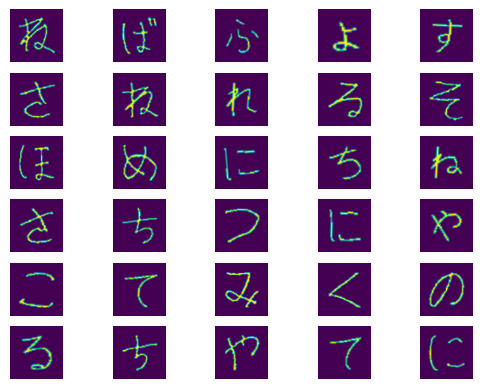

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Range for picking a value from.
datagen = ImageDataGenerator(
    rotation_range=5,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    shear_range=0.1,
    # zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2)


i = 0
for batch in datagen.flow(X_train_train, batch_size=1):
    plt.subplot(6,5,1 + i)
    plt.axis("off")
    
    augImage = batch[0]
    augImage = augImage.astype('float32')
    augImage /= 255
    plt.imshow(augImage)
    
    i += 1
    if i > 29:
        break

In [17]:
## train the model wuth data (including augmentaion datagen)
batch_size = 256  #128
nb_epoch = 16

# fits the model on batches with real-time data augmentation:
train_history = model.fit(datagen.flow(X_train_train, Y_train_train, batch_size=32),
         validation_data=(X_val, Y_val),
         batch_size=batch_size, epochs=nb_epoch, verbose=1,
         callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))


Epoch 1/16
32/32 [==============================] - 7s 193ms/step - loss: 2.1437 - accuracy: 0.4813 - val_loss: 0.3104 - val_accuracy: 0.9000
Epoch 2/16
32/32 [==============================] - 6s 188ms/step - loss: 0.2905 - accuracy: 0.9270 - val_loss: 0.1362 - val_accuracy: 0.9500
Epoch 3/16
32/32 [==============================] - 7s 208ms/step - loss: 0.1334 - accuracy: 0.9645 - val_loss: 0.2492 - val_accuracy: 0.9278
Epoch 4/16
32/32 [==============================] - 6s 200ms/step - loss: 0.0388 - accuracy: 0.9931 - val_loss: 0.2174 - val_accuracy: 0.9444
Epoch 5/16
32/32 [==============================] - 6s 188ms/step - loss: 0.0659 - accuracy: 0.9832 - val_loss: 0.1596 - val_accuracy: 0.9611
Epoch 6/16
32/32 [==============================] - 6s 187ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0501 - val_accuracy: 0.9833
Epoch 7/16
32/32 [==============================] - 6s 184ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0955 - val_accuracy: 0.9667
Epoch 

Plot the training process.

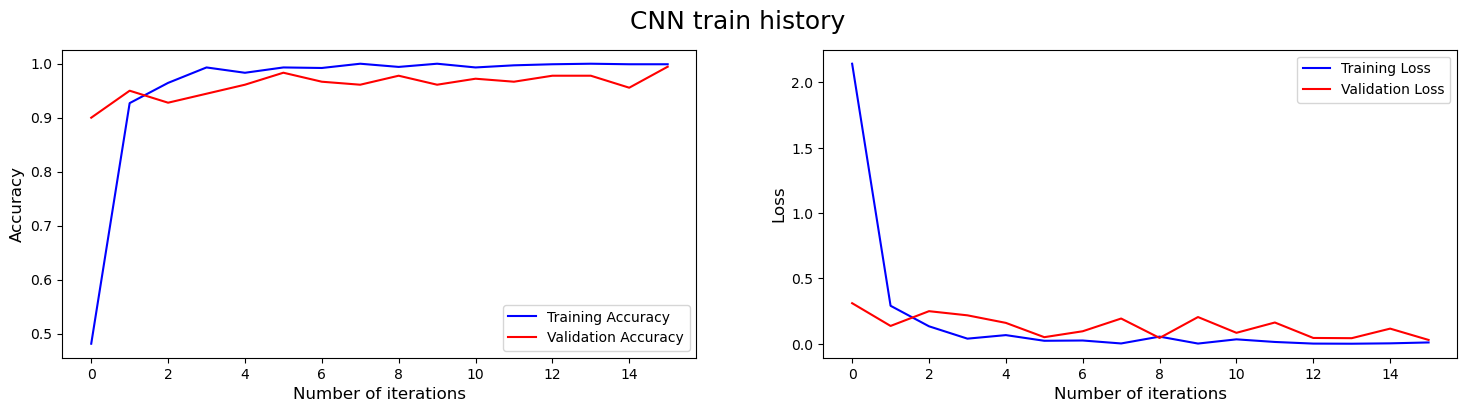

In [18]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(18,4))
plt.suptitle('CNN train history', fontsize=18)

ax1 = plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Number of iterations', fontsize=12)
plt.plot(train_history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='lower right')

ax2 = plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Number of iterations', fontsize=12)
plt.plot(train_history.history['loss'], color='b', label='Training Loss')
plt.plot(train_history.history['val_loss'], color='r', label='Validation Loss')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='upper right')
plt.show()

# Model Evaluation
Evaluate the model with testing data.

In [19]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 38ms/step - loss: 0.2571 - accuracy: 0.9479
Test score: 0.25714823603630066
Test accuracy: 0.9478672742843628


7/7 [==============================] - 0s 35ms/step
total testing data: 211
Number of errors = 11/211
Accuracy: 0.95


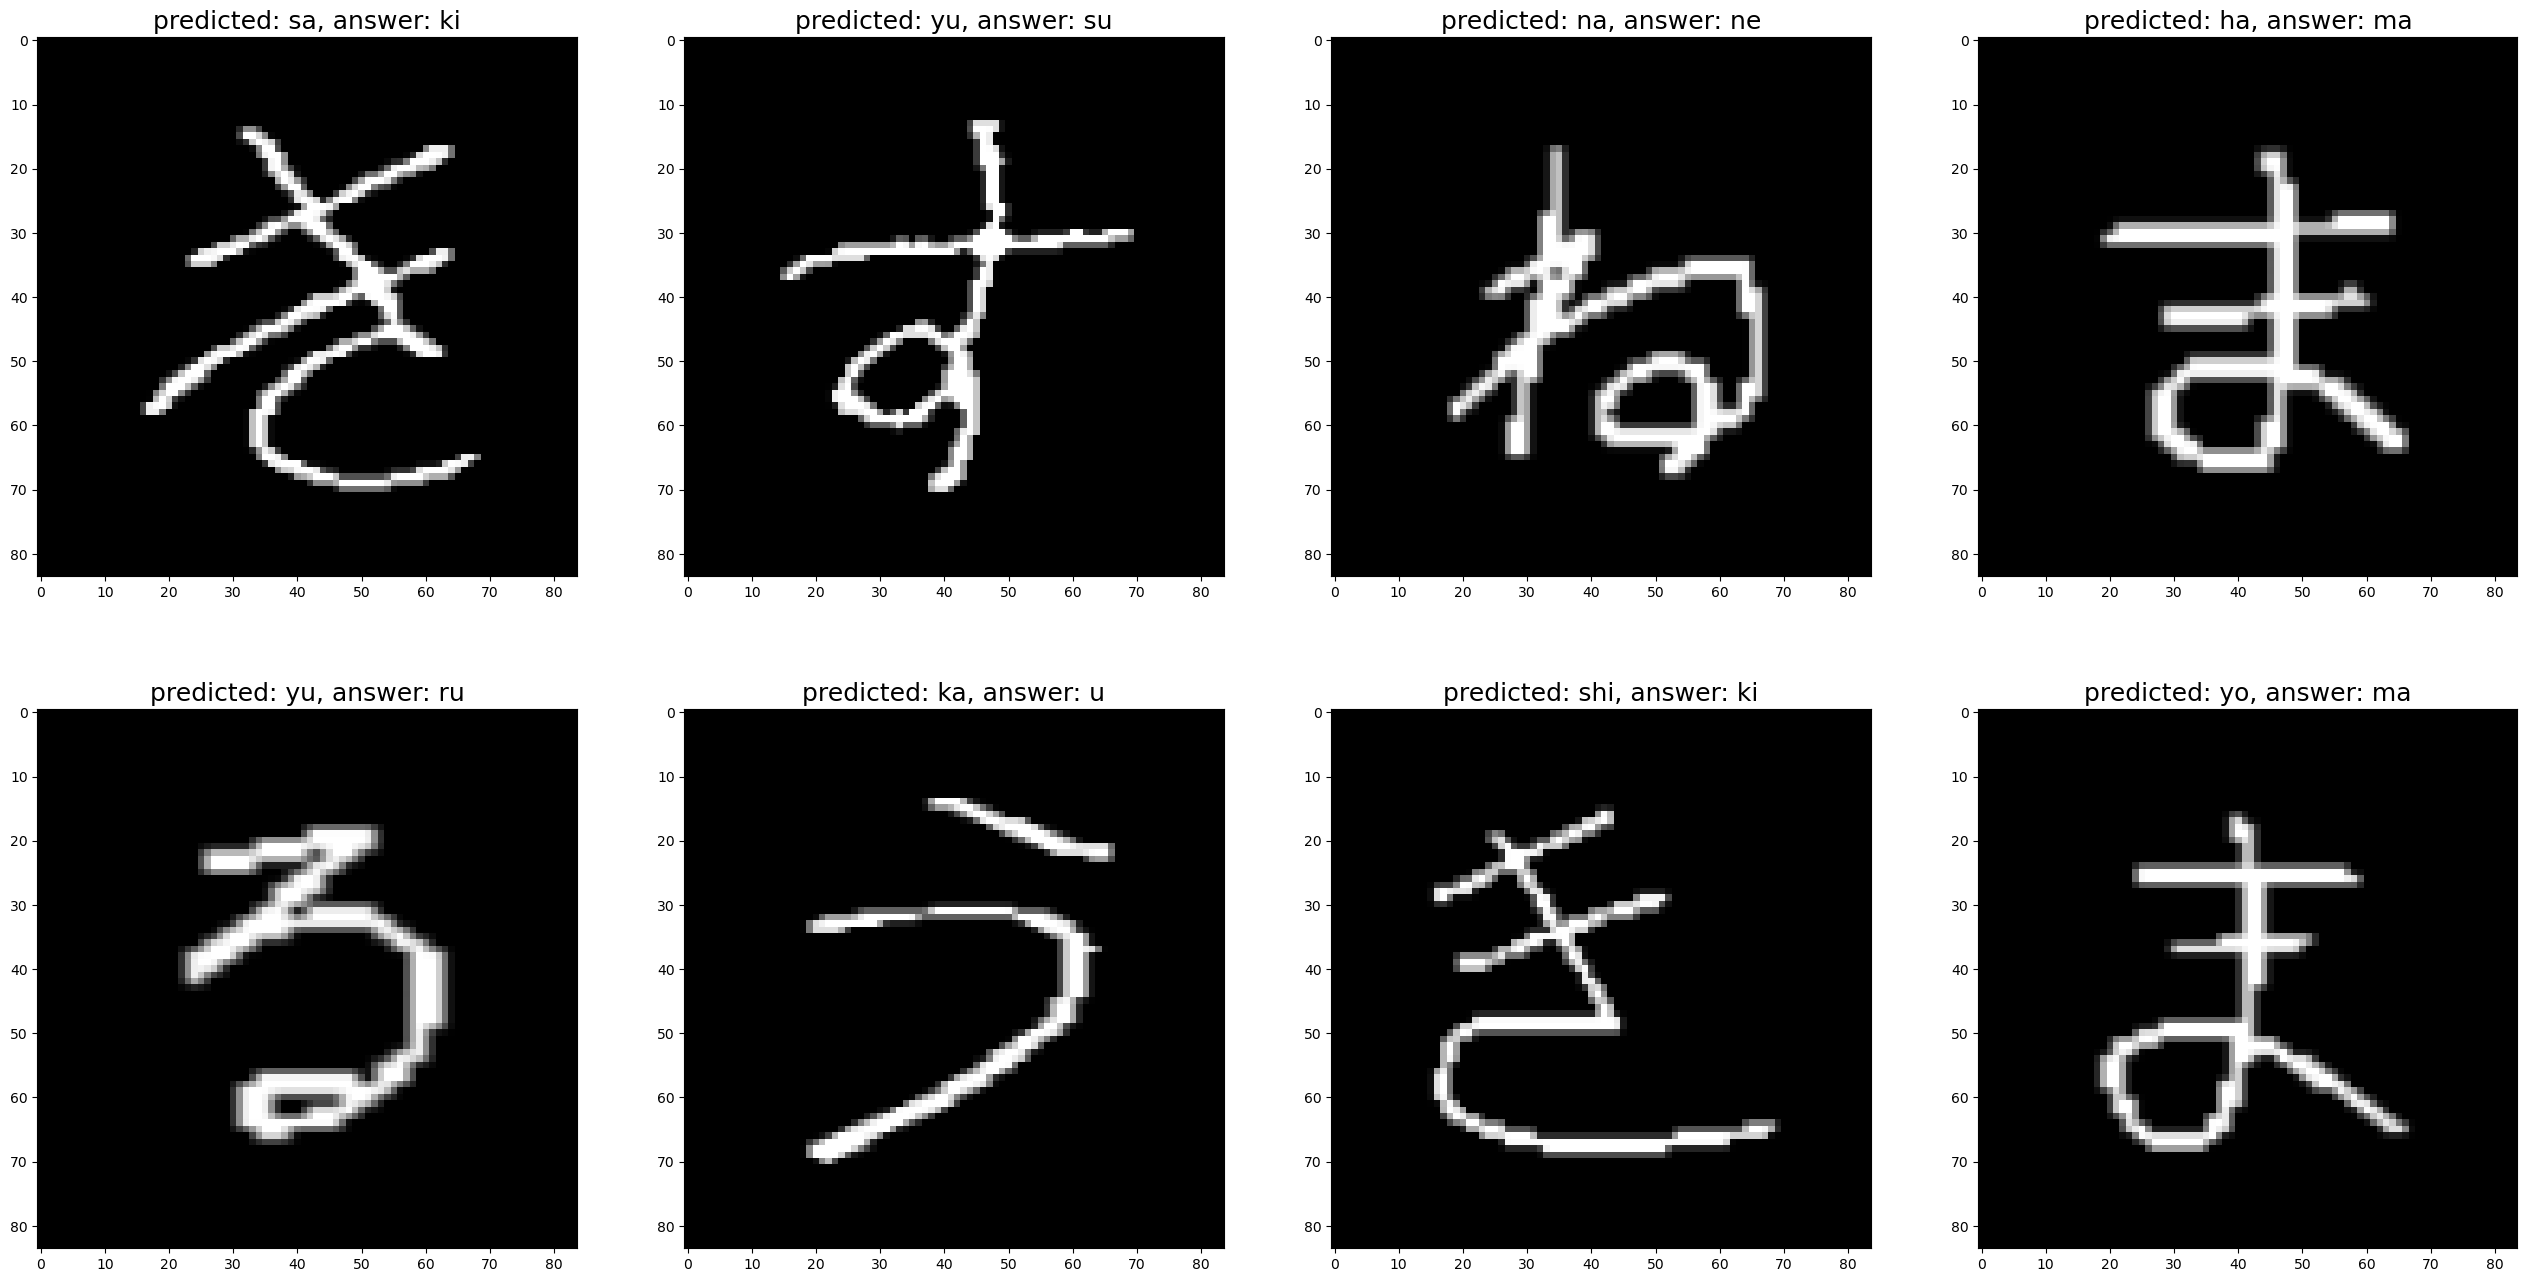

In [20]:
## show the (error) prediction results
from demonstration import get_predictions, show_errs

predictions = get_predictions(X_test, model)
ground_truth = y_test

show_errs(X_test, predictions, ground_truth, romanji_dict)

## Confusion matrix


In [21]:
confusion_matrix = np.zeros((romanji_categories, romanji_categories), dtype=np.uint8)

for predict, answer in zip(predictions, ground_truth):
    confusion_matrix[answer][predict] += 1
confusion_matrix


array([[4, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=uint8)

Confusion matrix, without normalization


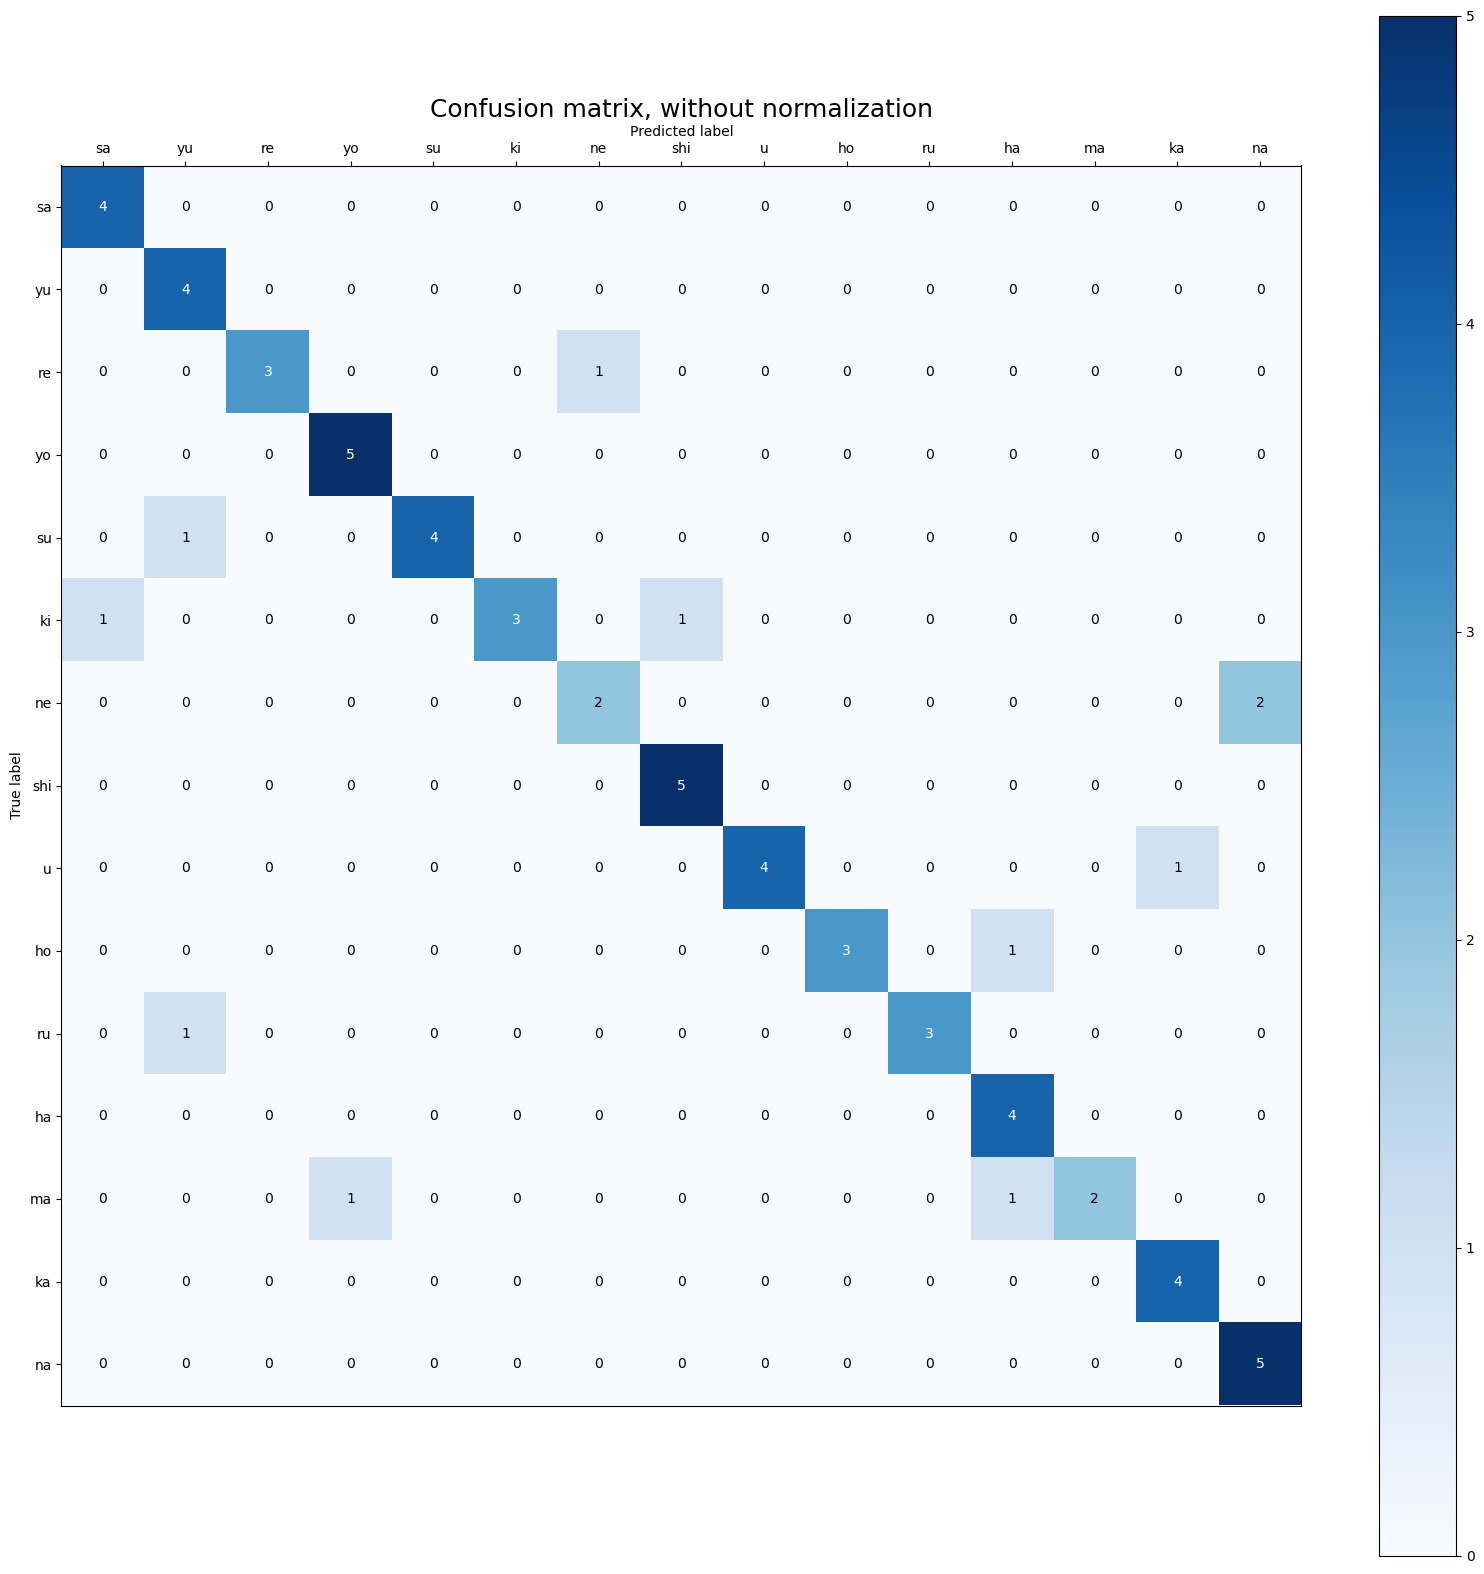

In [22]:
## plot confusion matrix (not normalized)
from demonstration import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix, romanji_dict,
                      title='Confusion matrix, without normalization')


In [23]:
# ## plot normalized confusion matrix
# plot_confusion_matrix(confusion_matrix, romanji_categories,
#                       normalize=True,
#                       title='Confusion matrix, with normalization')


## Cross Valiadation

In [24]:
from sklearn.model_selection import StratifiedKFold

# Assuming X and Y are your original data arrays
skf = StratifiedKFold(n_splits=5, shuffle=True) # , random_state=42

metrics = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    # create a validation set from the training set (for early stopping)
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_fold, y_train_fold, test_size=0.15, stratify=y_train_fold) # , shuffle=True

    Y_train_fold = np_utils.to_categorical(y_train_fold, romanji_categories)
    Y_val_fold = np_utils.to_categorical(y_val_fold, romanji_categories)
    Y_test_fold = np_utils.to_categorical(y_test_fold, romanji_categories)

    X_train_fold = std_X(X_train_fold)
    X_val_fold = std_X(X_val_fold)
    X_test_fold = std_X(X_test_fold)

    input_shape = (img_rows, img_cols, 1)

    model = build_hiragana_cnn(input_shape, romanji_categories)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    train_history = model.fit(datagen.flow(X_train_fold, Y_train_fold, batch_size=32),
                                validation_data=(X_val_fold, Y_val_fold),
                                batch_size=batch_size, epochs=nb_epoch, verbose=0,
                                callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))
    
    score = model.evaluate(X_test_fold, Y_test_fold, verbose=1)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    metrics.append(score[1])

metrics = np.array(metrics)
print('Mean accuracy:', metrics.mean())
print('Standard deviation:', metrics.std())

9/9 [==============================] - 0s 47ms/step - loss: 0.2944 - accuracy: 0.9644
Test score: 0.2943528890609741
Test accuracy: 0.9644128084182739
Epoch 7: early stopping
9/9 [==============================] - 0s 39ms/step - loss: 0.1838 - accuracy: 0.9537
Test score: 0.18377183377742767
Test accuracy: 0.9537366628646851
Epoch 6: early stopping
9/9 [==============================] - 0s 37ms/step - loss: 1.4880 - accuracy: 0.8577
Test score: 1.488027572631836
Test accuracy: 0.8576512336730957
Epoch 8: early stopping
9/9 [==============================] - 0s 41ms/step - loss: 0.1788 - accuracy: 0.9644
Test score: 0.1788291186094284
Test accuracy: 0.9644128084182739
Epoch 6: early stopping
9/9 [==============================] - 0s 42ms/step - loss: 0.3534 - accuracy: 0.9324
Test score: 0.35335972905158997
Test accuracy: 0.9323843121528625
Mean accuracy: 0.9345195651054382
Standard deviation: 0.04017414223147317


In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # , random_state=42

metrics = []
costs = []
models = []

for train_index, val_index in skf.split(X_train, y_train): # skf.split(X, y)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    Y_train_fold = np_utils.to_categorical(y_train_fold, romanji_categories)
    Y_val_fold = np_utils.to_categorical(y_val_fold, romanji_categories)

    X_train_fold = std_X(X_train_fold)
    X_val_fold = std_X(X_val_fold)

    model = build_hiragana_cnn(input_shape, romanji_categories)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    train_history = model.fit(datagen.flow(X_train_fold, Y_train_fold, batch_size=32),
                                validation_data=(X_val_fold, Y_val_fold),
                                batch_size=batch_size, epochs=nb_epoch, verbose=0,
                                callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))
    
    score = model.evaluate(X_val_fold, Y_val_fold, verbose=1)
    print('Validation score:', score[0])
    print('Validation accuracy:', score[1])
    costs.append(score[0])
    metrics.append(score[1])
    models.append(model)

metrics = np.array(metrics)
print('Mean accuracy:', metrics.mean())
print('Standard deviation:', metrics.std())

Epoch 9: early stopping
8/8 [==============================] - 0s 34ms/step - loss: 0.2507 - accuracy: 0.9623
Validation score: 0.25068461894989014
Validation accuracy: 0.9623430967330933
Epoch 6: early stopping
8/8 [==============================] - 0s 36ms/step - loss: 0.2027 - accuracy: 0.9456
Validation score: 0.20265088975429535
Validation accuracy: 0.9456067085266113
Epoch 12: early stopping
8/8 [==============================] - 0s 36ms/step - loss: 0.1585 - accuracy: 0.9749
Validation score: 0.15846620500087738
Validation accuracy: 0.9748954176902771
Epoch 6: early stopping
8/8 [==============================] - 0s 35ms/step - loss: 0.4033 - accuracy: 0.9289
Validation score: 0.4032957851886749
Validation accuracy: 0.9288703203201294
Epoch 16: early stopping
8/8 [==============================] - 0s 36ms/step - loss: 0.3120 - accuracy: 0.9328
Validation score: 0.3119986951351166
Validation accuracy: 0.9327731132507324
Mean accuracy: 0.9488977313041687
Standard deviation: 0.0174

In [27]:
# for model in models:
#     score = model.evaluate(X_test, Y_test, verbose=1)
#     print('Test score:', score[0])
#     print('Test accuracy:', score[1])

## decide the best model
model_vd = models[np.argmin(costs)]
## evaluate the best model
score = model_vd.evaluate(X_test, Y_test, verbose=1)

7/7 [==============================] - 0s 37ms/step - loss: 0.2060 - accuracy: 0.9621
Test score: 0.20595058798789978
Test accuracy: 0.9620853066444397
7/7 [==============================] - 0s 40ms/step - loss: 0.2525 - accuracy: 0.9479
Test score: 0.25246575474739075
Test accuracy: 0.9478672742843628
7/7 [==============================] - 0s 36ms/step - loss: 0.1554 - accuracy: 0.9573
Test score: 0.1553531140089035
Test accuracy: 0.9573459625244141
7/7 [==============================] - 0s 35ms/step - loss: 0.3410 - accuracy: 0.9384
Test score: 0.34095510840415955
Test accuracy: 0.9383886456489563
7/7 [==============================] - 0s 38ms/step - loss: 0.4352 - accuracy: 0.9384
Test score: 0.43515416979789734
Test accuracy: 0.9383886456489563


## Test my handwritings
Write hiraganas with paint-2D.

Test my hiragana handwritings with the trained model.

In [54]:
import re

my_handwritings = []
answers_myhw = []
for file in os.listdir("test_my_handwriting"):
    # print(file)
    key = re.search(r'_(\w+?)_', file).group(1)
    # print(key, end=", ")
    answers_myhw.append(key)
    img = cv.imread(f"test_my_handwriting/{file}", cv.IMREAD_GRAYSCALE)
    img = 255 - img
    # print(img.shape)
    img = im_reshape(im_bin(img), img_rows, img_cols)
    my_handwritings.append(img)

my_handwritings = np.array(my_handwritings)
print(my_handwritings.shape)
# print(answers_myhw)

(92, 84, 84)


(92, 84, 84, 1)
3/3 [==============================] - 0s 38ms/step
Number of errors_myhw = 24/92
Accuracy: 0.74


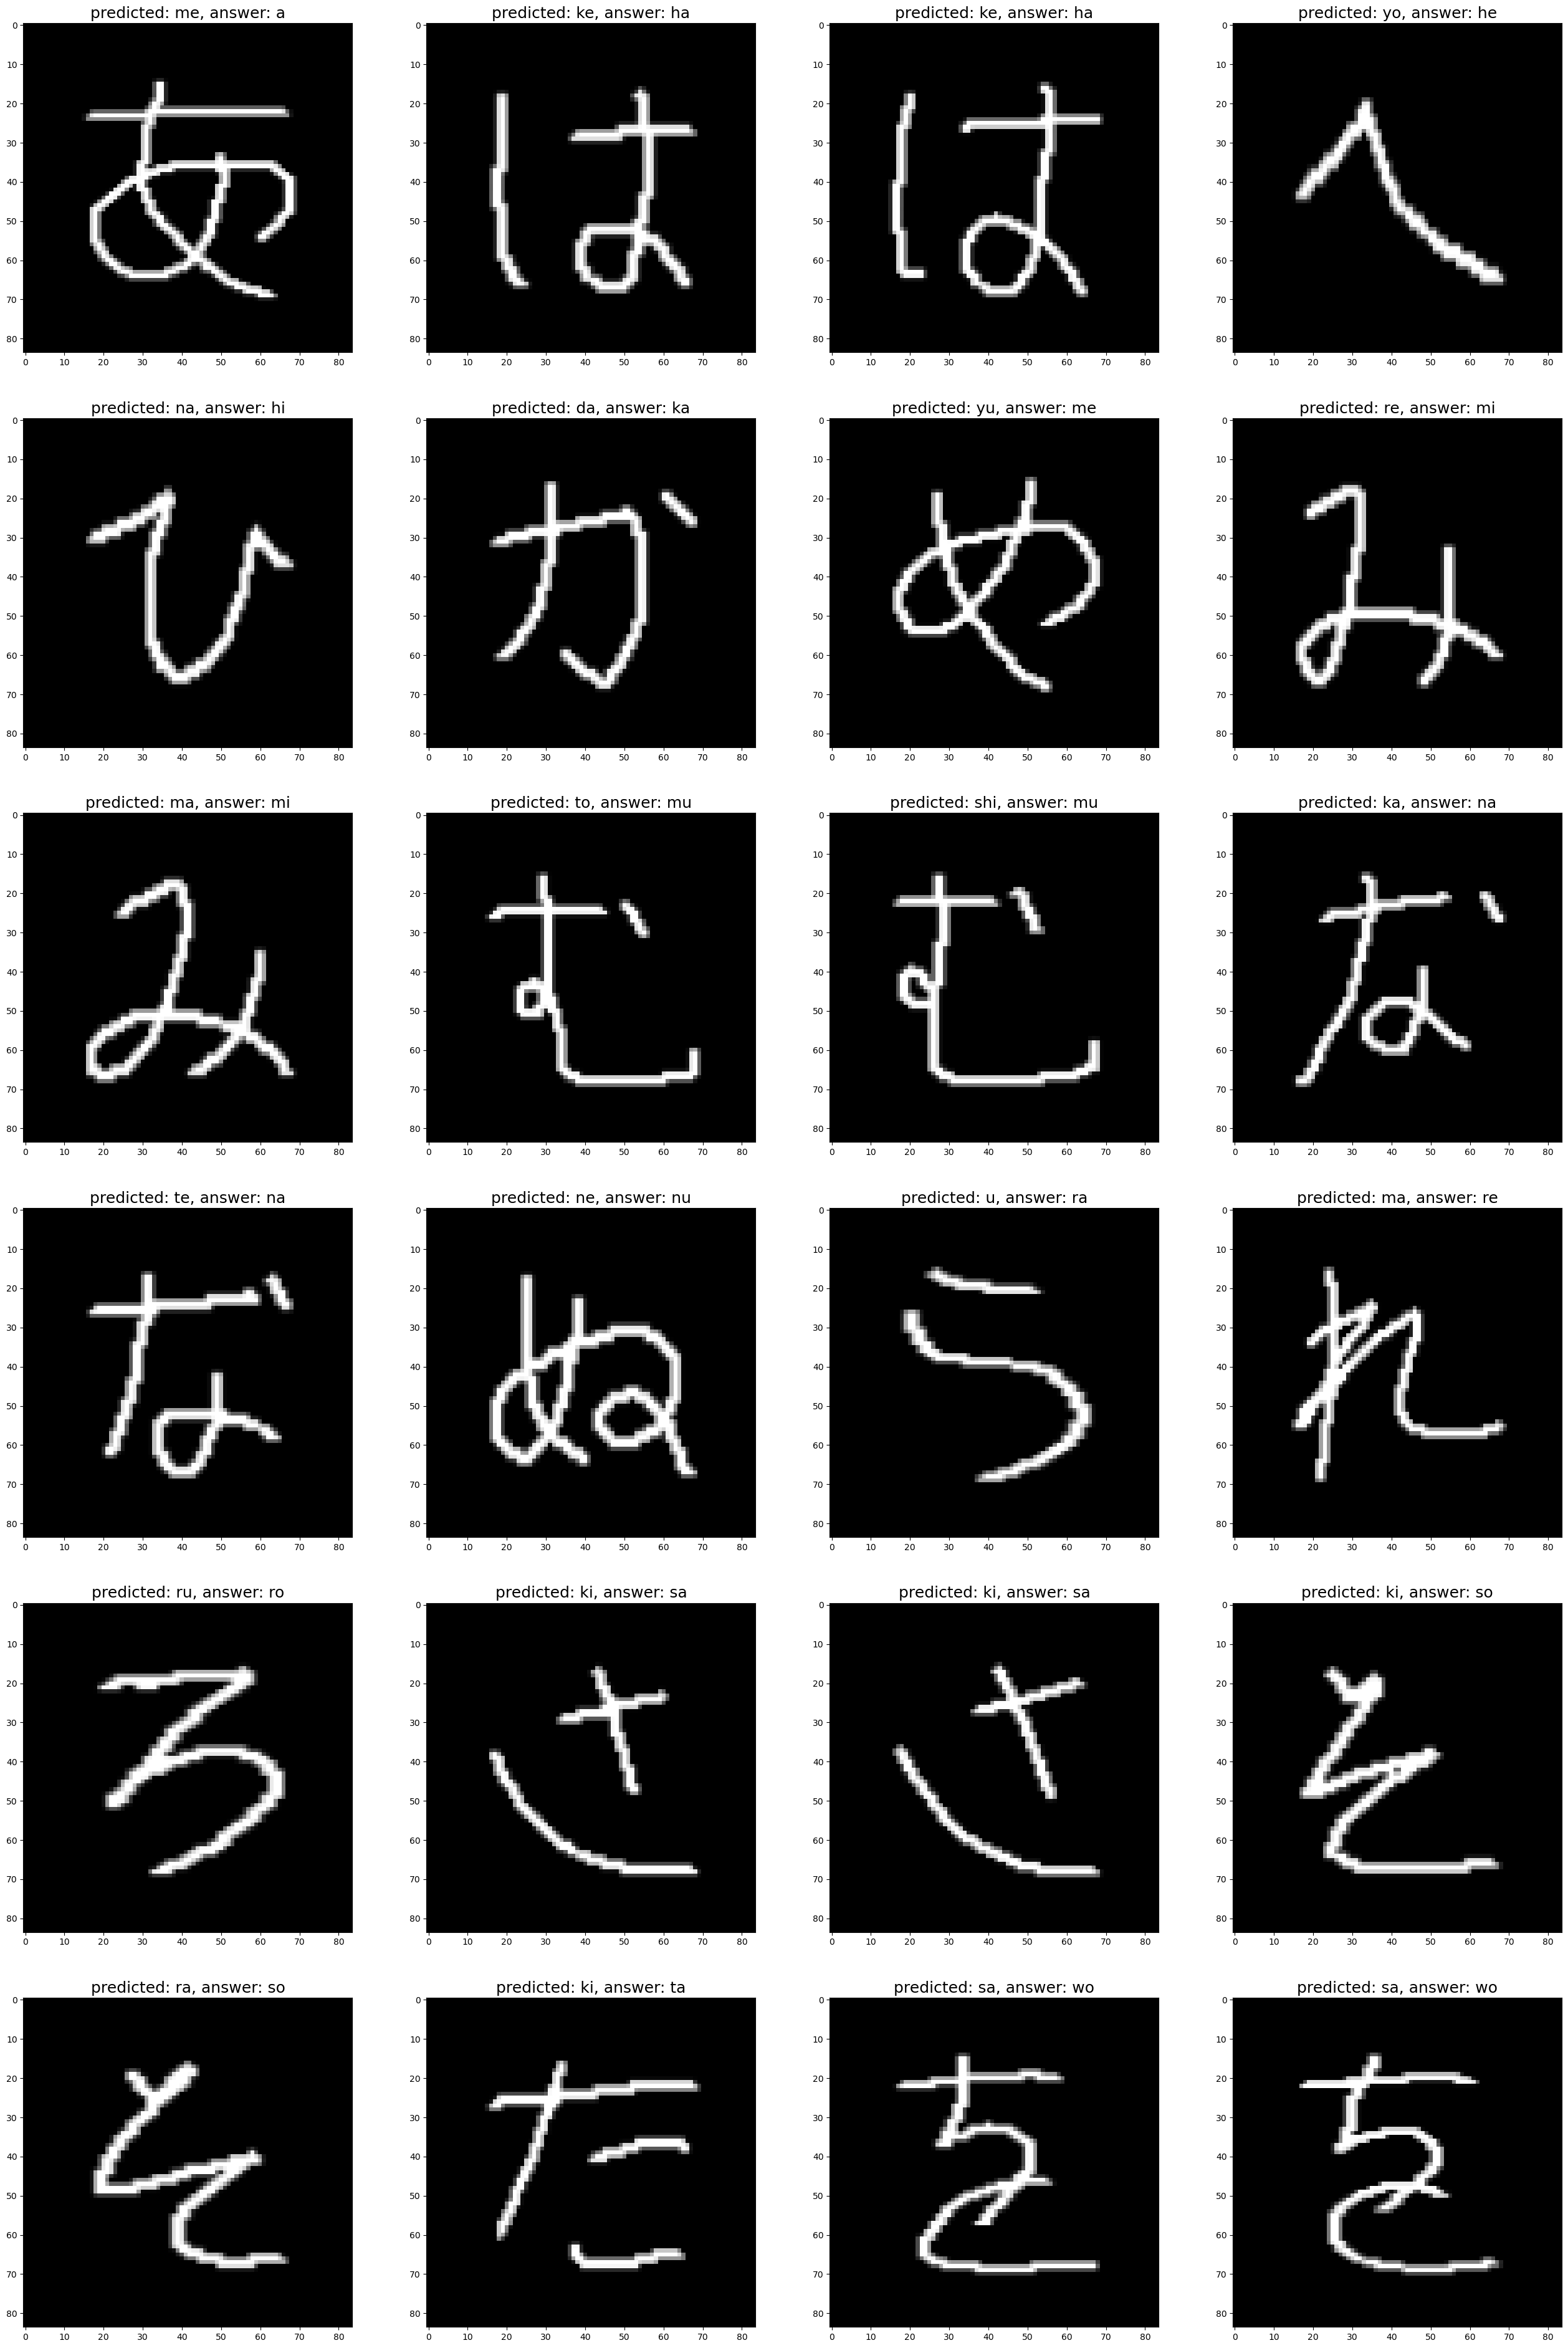

In [55]:
num_myhw = len(my_handwritings)
my_handwritings = my_handwritings.reshape(num_myhw, 84, 84, 1)
my_handwritings = std_X(my_handwritings)
print(my_handwritings.shape)
prob_myhw = model.predict(my_handwritings)
predictions_myhw = np.argmax(prob_myhw,axis=1)
# print(predictions_myhw)
prediction_romanji_myhw = [inv_romanji_dict[prediction] for prediction in predictions_myhw]
# print(prediction_romanji_myhw)
# print(answers_myhw)

errors_myhw = []
for i in range(num_myhw):
    if prediction_romanji_myhw[i] != answers_myhw[i]:
        errors_myhw.append(i)
# print(errors_myhw)
num_err_myhw = len(errors_myhw)
print("Number of errors_myhw = {}/{}".format(num_err_myhw,num_myhw))
print("Accuracy: {:.2f}".format(1-num_err_myhw/num_myhw))

num_eachrow = 4
rows_err = math.ceil(num_err_myhw / num_eachrow)
fig, axes = plt.subplots(rows_err, num_eachrow, figsize=(8*num_eachrow,8*rows_err))
for r in range(rows_err):
    for c in range(num_eachrow):
        n_err = r * num_eachrow + c
        if n_err >= num_err_myhw: break
        pos_err = errors_myhw[n_err]
        # plt.title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}")
        axes[r,c].set_title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}", fontsize=18)
        axes[r,c].imshow(my_handwritings[pos_err], cmap=plt.get_cmap('gray'))

Save the model

In [ ]:
# from keras.models import load_model
# # creates a HDF5 file
# model.save('model_hiragana_recognition_cnn.h5') 
